In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import cluster_jzar
import climb_jor

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows', 10)

### We have 3 types of data:
- `Independent features (clustered)` => <b>In this notebook we will work on this one
- How good the route is (the higher the better)
- Grade, Location, sex, heigh (defined by user)


# Clustering Routes

First we retrieve the features dataframe

In [3]:
routes_features = pd.read_csv('../data/routes_features.csv',low_memory=False, index_col=0)

In [4]:
print(routes_features.shape)
routes_features.tail(5)

(55858, 19)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,sex_ratio,yellow_id_mean,first_ascent_mean
55853,55853,zaf,van stadens,cleopatra wall,steel sunday,3,0.0,2.0,1.0,0,0,0,0,40.0,0.4753,NaN,0.0,255.0,0.0
55854,55854,zaf,van stadens,cleopatra wall,suck it up princess,2,0.0,0.0,0.0,0,0,0,0,44.0,0.7074,NaN,0.0,127.5,0.0
55855,55855,zaf,van stadens,cleopatra wall,sunset sonata,2,0.0,0.0,0.0,1,0,0,1,54.5,0.8636,3.0,0.0,255.0,0.5
55856,55856,zaf,van stadens,cleopatra wall,tekel,2,0.0,1.0,0.0,0,0,0,0,44.0,NaN,2.0,0.0,0.0,0.0
55857,55857,zaf,waterval boven,baboon buttress,pretenders,2,0.0,1.0,0.0,0,0,0,0,49.0,0.8020,NaN,0.0,255.0,0.0


## Prepare the dataframe for clustering

In [5]:
# Drop not interesting features
X = routes_features[['ascents_count','repeat_sum','chiped_sum','soft_sum','hard_sum','traditional_sum','tall_recommend_sum','sex_ratio','yellow_id_mean','first_ascent_mean']]

In [6]:
X.corr()

,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio,yellow_id_mean,first_ascent_mean
ascents_count,1.000000,0.315688,0.083742,0.726498,0.571449,0.045345,0.071629,0.044584,0.212546,-0.058248
repeat_sum,0.315688,1.000000,0.014805,0.195030,0.157301,0.090234,0.044551,0.002862,0.074844,-0.009543
chiped_sum,0.083742,0.014805,1.000000,0.086912,0.071868,-0.005966,0.013689,-0.024766,0.021863,0.007426
soft_sum,0.726498,0.195030,0.086912,1.000000,0.213342,0.003225,0.127405,0.002530,0.167114,-0.033857
hard_sum,0.571449,0.157301,0.071868,0.213342,1.000000,0.023404,-0.035391,-0.002364,0.152365,-0.042649
traditional_sum,0.045345,0.090234,-0.005966,0.003225,0.023404,1.000000,-0.003125,-0.006528,0.040668,-0.011586
tall_recommend_sum,0.071629,0.044551,0.013689,0.127405,-0.035391,-0.003125,1.000000,0.005641,0.008285,-0.002380
sex_ratio,0.044584,0.002862,-0.024766,0.002530,-0.002364,-0.006528,0.005641,1.000000,0.039665,-0.049881
yellow_id_mean,0.212546,0.074844,0.021863,0.167114,0.152365,0.040668,0.008285,0.039665,1.000000,-0.037680
first_ascent_mean,-0.058248,-0.009543,0.007426,-0.033857,-0.042649,-0.011586,-0.002380,-0.049881,-0.037680,1.000000


<AxesSubplot:>

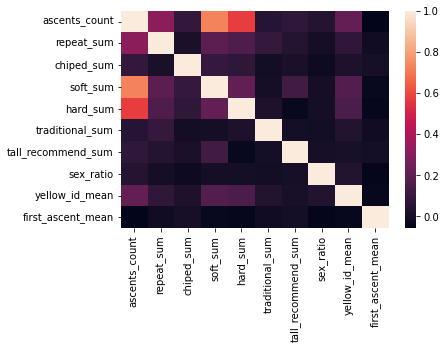

In [7]:
sns.heatmap(X.corr())

Not a big correlation between features

In [8]:
X

,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio,yellow_id_mean,first_ascent_mean
0,4,0.0,0.0,0,1,0,-1,0.0,0.0,0.0
1,6,0.0,0.0,1,1,0,-1,0.0,0.0,0.0
2,5,0.0,0.0,0,0,0,0,0.0,0.0,0.0
3,3,0.0,0.0,0,1,0,0,0.0,0.0,0.0
4,2,0.0,0.0,1,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
55853,3,0.0,1.0,0,0,0,0,0.0,255.0,0.0
55854,2,0.0,0.0,0,0,0,0,0.0,127.5,0.0
55855,2,0.0,0.0,1,0,0,1,0.0,255.0,0.5
55856,2,0.0,0.0,0,0,0,0,0.0,0.0,0.0


In [9]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "../transformer/scaler.pickle" # Path with filename
with open(filename, "wb") as file:
        pickle.dump(scaler,file)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
print(X_scaled_df.shape)
display(X_scaled_df.head(3))

(55858, 10)


,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio,yellow_id_mean,first_ascent_mean
0,-0.326844,-0.218995,-0.113572,-0.342544,0.182314,-0.098883,-1.059586,-0.611235,-1.074365,-0.198984
1,-0.237211,-0.218995,-0.113572,0.036434,0.182314,-0.098883,-1.059586,-0.611235,-1.074365,-0.198984
2,-0.282028,-0.218995,-0.113572,-0.342544,-0.425887,-0.098883,-0.023864,-0.611235,-1.074365,-0.198984


### Check the PCA

In [10]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.22867544, 0.10739323, 0.10466672, 0.10353983, 0.09697261,
       0.09472296, 0.09134568, 0.0819937 , 0.07431831, 0.01637153])

All pcas have more or less hte same variance ratio

# Clustering model - K-Means

In [11]:
# K = range(2, 21)
# inertia = []
# silhouette = []

# for k in K:
#     print("Training a K-Means model with {} neighbours! ".format(k))
#     print()
#     kmeans = KMeans(n_clusters=k,
#                     random_state=1234)
#     kmeans.fit(X_scaled_df)
#     filename = "../model/kmeans_" + str(k) + ".pickle" # Path with filename
#     with open(filename, "wb") as file:
#         pickle.dump(kmeans,file)
#     inertia.append(kmeans.inertia_)
#     silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))

Training a K-Means model with 2 neighbours! 

Training a K-Means model with 3 neighbours! 

Training a K-Means model with 4 neighbours! 

Training a K-Means model with 5 neighbours! 

Training a K-Means model with 6 neighbours! 

Training a K-Means model with 7 neighbours! 

Training a K-Means model with 8 neighbours! 

Training a K-Means model with 9 neighbours! 

Training a K-Means model with 10 neighbours! 

Training a K-Means model with 11 neighbours! 

Training a K-Means model with 12 neighbours! 

Training a K-Means model with 13 neighbours! 

Training a K-Means model with 14 neighbours! 

Training a K-Means model with 15 neighbours! 

Training a K-Means model with 16 neighbours! 

Training a K-Means model with 17 neighbours! 

Training a K-Means model with 18 neighbours! 

Training a K-Means model with 19 neighbours! 

Training a K-Means model with 20 neighbours! 



I will 3D plot in 2 groups


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

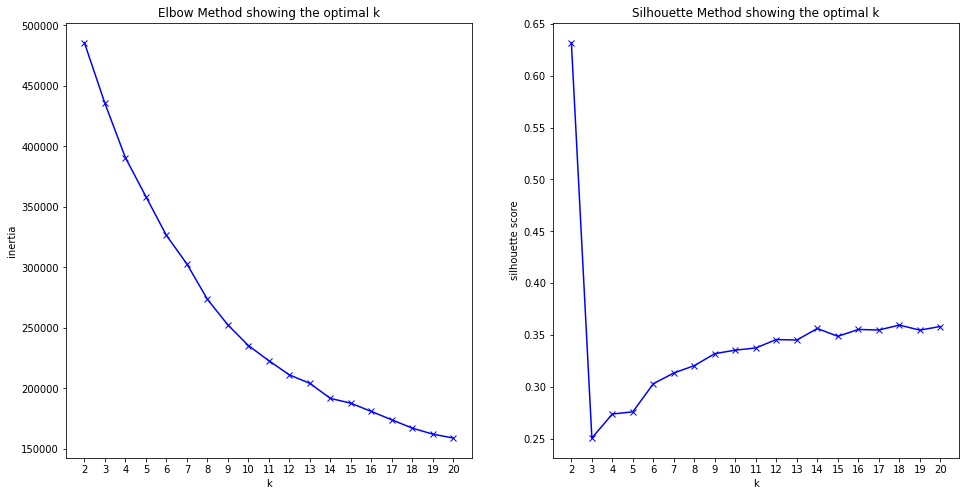

In [12]:
# fig, ax = plt.subplots(1,2,figsize=(16,8))
# ax[0].plot(K, inertia, 'bx-')
# ax[0].set_xlabel('k')
# ax[0].set_ylabel('inertia')
# ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
# ax[0].set_title('Elbow Method showing the optimal k')
# ax[1].plot(K, silhouette, 'bx-')
# ax[1].set_xlabel('k')
# ax[1].set_ylabel('silhouette score')
# ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
# ax[1].set_title('Silhouette Method showing the optimal k')

We will take 4

In [60]:
k = 4
filename = "../model/kmeans_" + str(k) + ".pickle" # Path with filename
with open(filename, "rb") as file:
    kmeans = pickle.load(file)
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index() # Number of songs in each cluster

0    27067
1    25417
2     1520
3     1854
dtype: int64

In [61]:
clusters

array([0, 0, 0, ..., 2, 0, 1], dtype=int32)

### Check the PCA

In [62]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.22867544, 0.10739323, 0.10466672, 0.10353983, 0.09697261,
       0.09472296, 0.09134568, 0.0819937 , 0.07431831, 0.01637153])

Just for fun I will 3D plot but we have 8 groups... impossible to visualize with the limited human brain..

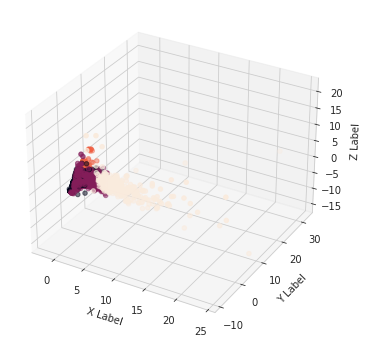

In [63]:
from plot_jzar import *
# %matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[1],z = principalDf[2],color = clusters, fraction = 0.2)

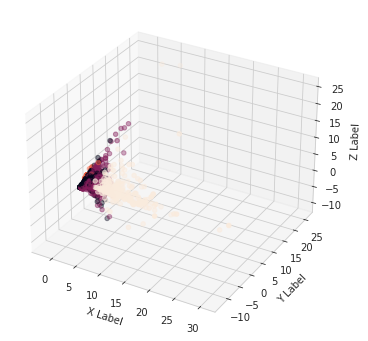

In [64]:
# %matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[2],z = principalDf[3],color = clusters, fraction = 0.2)

And we see that the assigned clusters are not so bad

### Assing each route to a cluster

In [65]:
X_cl = routes_features.copy()
X_cl["cluster"] = pd.Series(clusters)

In [66]:
routes_clustered = X_cl.drop(columns = ['chiped_sum','soft_sum','hard_sum','traditional_sum','sex_ratio'])
print(routes_clustered.shape)
routes_clustered.head()

(55858, 15)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,yellow_id_mean,first_ascent_mean,cluster
0,0,and,montserrat,prohibitivo,diagonal de la x,4,0.0,0.0,-1,49.250000,0.0000,2.00,0.0,0.0,0
1,1,and,montserrat,prohibitivo,mehir,6,0.0,1.0,-1,49.000000,0.0000,2.00,0.0,0.0,0
2,2,and,montserrat,prohibitivo,pas de la discordia,5,0.0,1.0,0,49.000000,0.0000,1.75,0.0,0.0,0
3,3,and,tartareu,bombo suis,tenedor libre,3,0.0,1.0,0,44.333333,0.0000,3.00,0.0,0.0,0
4,4,arg,bandurrias,rincon,tendinitis,2,0.0,0.0,1,48.500000,0.0762,1.00,0.0,0.0,0


In [67]:
clust_0 = routes_clustered[routes_clustered.cluster == 0]

In [68]:
routes_clustered.cluster.value_counts()

0    27067
1    25417
3     1854
2     1520
Name: cluster, dtype: int64

In [69]:
routes_clustered.to_csv('../data/routes_clustered.csv')